In [31]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

image_folder = r'E:\CPV\Lab1\images'
compression_mode = 'lossy'             # Chọn 'lossless' hoặc 'lossy'
lossy_threshold = None
keep_ratio = 0.04               


In [32]:
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
if not image_files:
    raise ValueError("Không tìm thấy ảnh trong thư mục đã cho.")

random_image_file = random.choice(image_files)
img_path = os.path.join(image_folder, random_image_file)
img = cv2.imread(img_path)
if img is None:
    raise ValueError("Không đọc được ảnh, hãy kiểm tra lại đường dẫn hoặc định dạng ảnh.")

# Chuyển ảnh từ BGR sang RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# In ra thông tin ảnh
print(f"Ảnh được chọn: {random_image_file}")
print("Kích thước (rows, cols, channels):", img.shape)
print("Dung lượng file ảnh (bytes):", os.path.getsize(img_path))

# Nếu ảnh là grayscale, chuyển thành ảnh màu (3 kênh)
if img.ndim == 2:
    img = np.stack((img, img, img), axis=-1)
print("Shape of image:", img.shape)

# Tính dung lượng dữ liệu gốc (uint8 mỗi pixel)
original_size_bytes = img.nbytes
print("Dung lượng ảnh gốc (dữ liệu thô): {} bytes".format(original_size_bytes))


Ảnh được chọn: 6399_sat_32.jpg
Kích thước (rows, cols, channels): (256, 256, 3)
Dung lượng file ảnh (bytes): 32019
Shape of image: (256, 256, 3)
Dung lượng ảnh gốc (dữ liệu thô): 196608 bytes


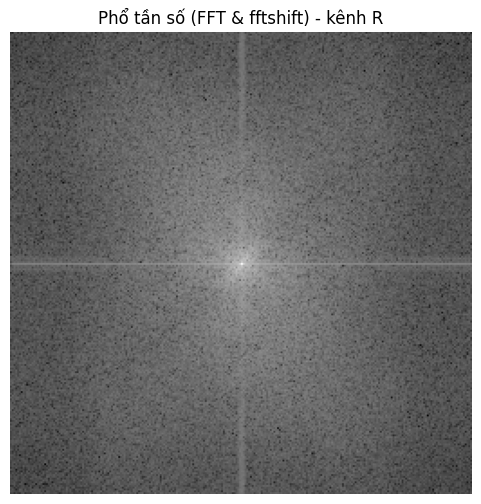

In [33]:
# Tính FFT 2D cho từng kênh và dời trung tâm (fftshift)
F_channels = []
for ch in range(img.shape[2]):
    channel = img[..., ch].astype(np.float64)
    F = np.fft.fft2(channel)
    Fshift = np.fft.fftshift(F)
    F_channels.append(Fshift.astype(np.complex64))

# Tính phổ biên độ (log scale) cho kênh R (index 0) để hiển thị
magnitude_spectrum = np.log(np.abs(F_channels[0]) + 1)

# Hiển thị phổ tần số ban đầu của kênh R
plt.figure(figsize=(6, 6))
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title("Phổ tần số (FFT & fftshift) - kênh R")
plt.axis('off')
plt.show()


In [34]:
# Khởi tạo danh sách lưu kết quả FFT sau khi lọc
F_channels_filtered = []  # Mỗi phần tử là tuple (F_filtered, mask)
nonzero_count_total = 0
total_coeff_total = 0

for Fshift in F_channels:
    absF = np.abs(Fshift)
    
    if compression_mode.lower() == 'lossless':
        # Ở chế độ lossless, giữ lại tất cả hệ số (mask toàn bộ True)
        mask = np.ones_like(Fshift, dtype=bool)
    elif compression_mode.lower() == 'lossy':
        if lossy_threshold is not None:
            # Dùng ngưỡng tuyệt đối do người dùng cung cấp
            mask = absF >= lossy_threshold
        else:
            # Tính ngưỡng dựa trên keep_ratio: giữ lại keep_ratio*100% hệ số có biên độ lớn nhất
            threshold = np.percentile(absF, 100 * (1 - keep_ratio))
            mask = absF >= threshold
    else:
        raise ValueError("compression_mode phải là 'lossless' hoặc 'lossy'")
    
    F_filtered = Fshift * mask
    F_channels_filtered.append((F_filtered, mask))
    
    nonzero_count_total += np.count_nonzero(mask)
    total_coeff_total += Fshift.size

print("Tổng số hệ số FFT (cho 3 kênh):", total_coeff_total)
print("Số hệ số được giữ lại sau nén (cho 3 kênh):", nonzero_count_total)

# Ước tính dung lượng sau nén (giả sử lưu dạng sparse: 2 chỉ số (4 byte mỗi chỉ số) + 1 giá trị complex128 (16 bytes) = 24 bytes)
bytes_per_coeff = 24
compressed_size_bytes = nonzero_count_total * bytes_per_coeff
print("Ước tính dung lượng dữ liệu sau nén:", compressed_size_bytes, "bytes")

compression_ratio = compressed_size_bytes / original_size_bytes
print("Tỷ lệ nén (dung lượng sau / dung lượng trước): {:.2f}%".format(compression_ratio * 100))


Tổng số hệ số FFT (cho 3 kênh): 196608
Số hệ số được giữ lại sau nén (cho 3 kênh): 7869
Ước tính dung lượng dữ liệu sau nén: 188856 bytes
Tỷ lệ nén (dung lượng sau / dung lượng trước): 96.06%


In [35]:
# Tái tạo ảnh từ các hệ số FFT đã lọc
reconstructed_channels = []
for F_filtered, mask in F_channels_filtered:
    # Chuyển ngược fftshift
    F_ishift = np.fft.ifftshift(F_filtered)
    # Tính FFT nghịch đảo
    channel_reconstructed = np.fft.ifft2(F_ishift)
    # Lấy phần trị tuyệt đối để có giá trị thực
    channel_reconstructed = np.abs(channel_reconstructed)
    reconstructed_channels.append(channel_reconstructed)

# Ghép các kênh lại thành ảnh màu
img_reconstructed = np.stack(reconstructed_channels, axis=-1)
img_reconstructed = np.clip(img_reconstructed, 0, 255).astype(np.uint8)


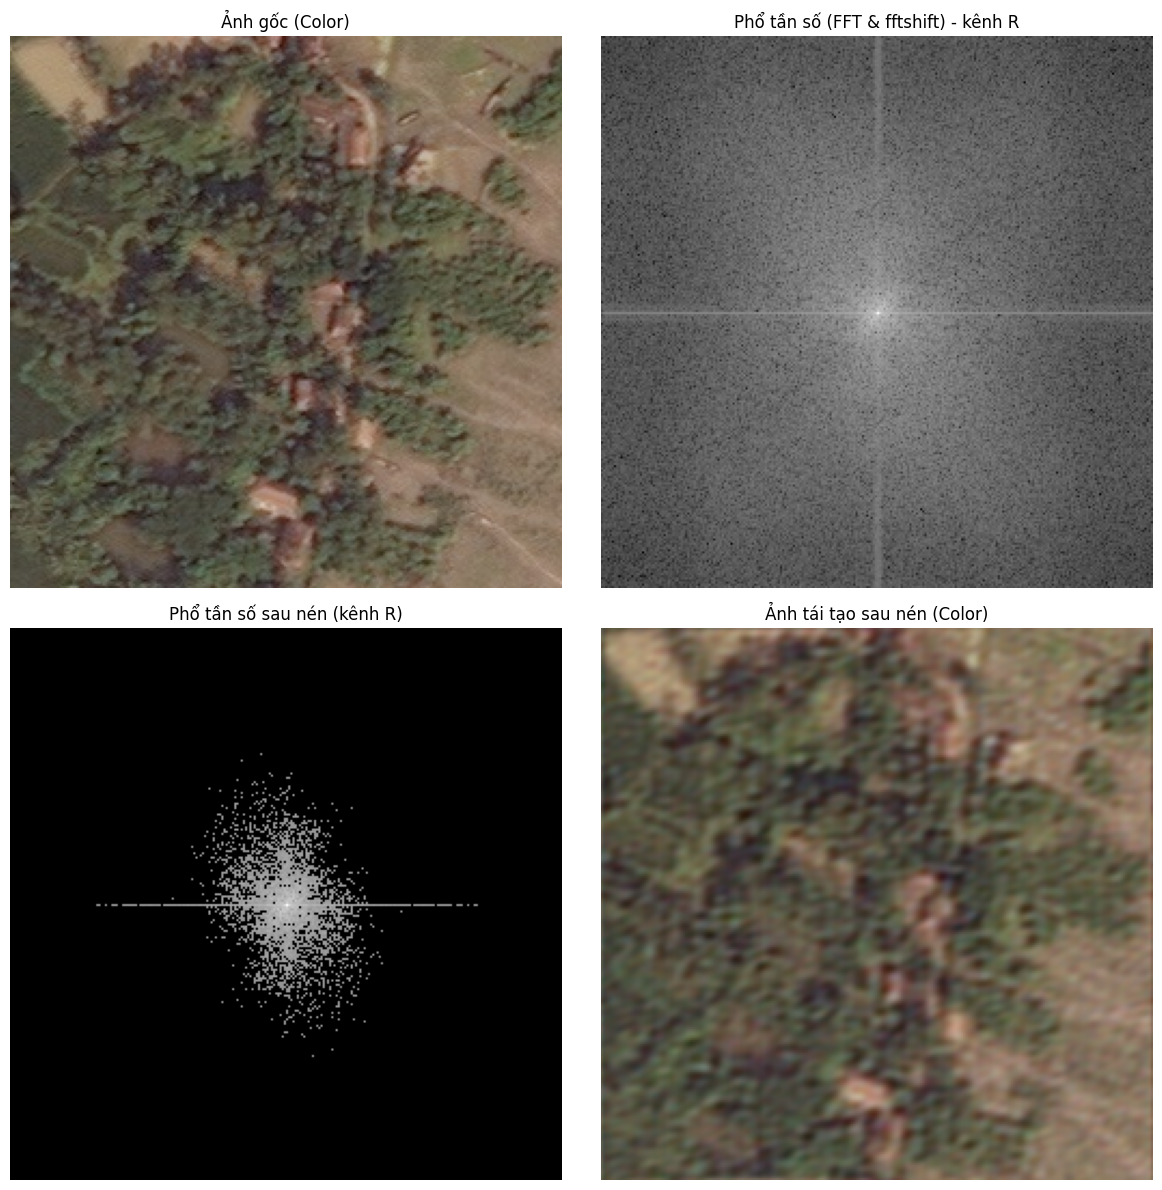

In [36]:
plt.figure(figsize=(12, 12))

# Ảnh gốc
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title("Ảnh gốc (Color)")
plt.axis('off')

# Phổ tần số ban đầu của kênh R
plt.subplot(2, 2, 2)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title("Phổ tần số (FFT & fftshift) - kênh R")
plt.axis('off')

# Phổ tần số sau nén của kênh R
plt.subplot(2, 2, 3)
magnitude_filtered = np.log(np.abs(F_channels_filtered[0][0]) + 1)
plt.imshow(magnitude_filtered, cmap='gray')
plt.title("Phổ tần số sau nén (kênh R)")
plt.axis('off')

# Ảnh tái tạo sau nén
plt.subplot(2, 2, 4)
plt.imshow(img_reconstructed)
plt.title("Ảnh tái tạo sau nén (Color)")
plt.axis('off')

plt.tight_layout()
plt.show()
